# Informatyka w medycynie

## **Tomograf**

*Grupa dwuosobowa: Ivan Kaliadzich 153936, Mikołaj Diakowski 151843*

In [99]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom as pd
from pydicom.dataset import FileDataset, FileMetaDataset, validate_file_meta
from pydicom.uid import UID, generate_uid
from PIL import Image
import math
import imageio.v2 as imageio
from scipy import misc, signal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


# inicjalizacja zmiennych
d_x =1.0
d_a = d_x*math.pi/180
range_pi=math.pi 
n_detect=180
filter = True

### Algorytm Bresenhama

In [100]:
def Alg_Bresenhama(x0, y0, x1, y1):
    x = x0
    y= y0
    points = []
    if x0 < x1 :
        xi=1
        dx = x1 - x0
    else:
        xi=-1
        dx = x0 - x1
    if y0 < y1:
        yi=1
        dy = y1 - y0
    else: 
        yi=-1
        dy = y0 - y1

    points.append((x,y))

    if dx>dy:
        ai = (dy-dx)*2
        bi = dy*2
        d =bi-dx
        while x!=x1:
            if d>= 0:
                x+=xi
                y+=yi
                d+=ai
            else:
                d+=bi
                x+=xi
            points.append((x,y))
    else:
        ai= (dx-dy)*2
        bi =dx*2
        d= bi-dy
        while y!=y1:
            if d>=1:
                x+=xi
                y+=yi
                d+=ai
            else:
                d+=bi
                y+=yi
            points.append((x,y))

    return points

### Transformacja Radona

In [101]:
def Transf_Radona (photo , d_a, range_pi, n_detect, d_x):
    alfa = math.pi/2
    n = math.ceil(180/d_x)+1
    detectors = [[0,0] for i in range(n_detect)]
    emitery = [[0,0] for i in range(n_detect)]
    Length = len(photo)
    Width = len(photo[0])
    r = math.floor (math.sqrt(Length*Length+Width*Width)/2)

    photo1 = [[0 for i in range(r*2)] for j in range(r*2)]
    l, w = photo.shape
    y_off = round((r*2-l)/2)
    x_off = round((r*2-w)/2)
    photo1= np.array(photo1.copy())
    photo1[y_off:y_off+l ,x_off:x_off+w] = photo

    sinogram=[]

    for i in range(n):
        str = [0 for j in range(n_detect)]
        for j in range(n_detect):
            x = r*math.cos(alfa + math.pi - (1/2)*range_pi + j*(range_pi/(n_detect-1))+(i*d_a))
            y = r*math.sin(alfa + math.pi - (1/2)*range_pi + j*(range_pi/(n_detect-1))+(i*d_a))
            
            detectors[j] = [round(x) ,round(y)]
            x_e  = r*math.cos(alfa + (1/2)*range_pi - j*(range_pi/(n_detect-1))+(i*d_a))
            y_e = r*math.sin( alfa + (1/2)*range_pi - j*(range_pi/(n_detect-1))+(i*d_a))
            emitery[j]=[round(x_e),round(y_e)]
            points = Alg_Bresenhama( emitery[j][0], emitery[j][1], detectors[j][0] ,detectors[j][1])
            k =1

            for x_p ,y_p in points:
                if(x_p+r > x_off and y_p+r > y_off  and x_p+r < x_off+w and y_p+r < y_off+l):
                    str[j] += photo1[x_p+r-1][y_p+r-1]
                    k+=1 

            if k>1:
                k-= 1
            str[j]/=k

        sinogram.append(str)

    sinogram = np.rot90(sinogram, 1 , axes  = (0,1))
    return sinogram

### Projekcja wsteczna

In [102]:
def Back_Projection(sinogram, d_x):
    x = np.arange(sinogram.shape[0])-sinogram.shape[0]/2 
    y = x.copy()
    ox, oy = np.meshgrid(x, y)
    projection  = []
    num  = sinogram.shape[0]
    constr  = np.array([[0 for i in range(num )] for j in range(num )])
    angle = np.arange(0.0,180,d_x)*(-1)*math.pi/180

    for j in range(len(angle)):
        projekcja = np.array([[0 for i in range(num)] for j in range(num )])
        rot = ox*math.sin(angle[j])-oy*math.cos(angle[j])
        punkty = np.round(rot + num /2)
        punkty = punkty.astype('int')
        p1, p2 = np.where((punkty>=0) & (punkty<num))
        linia = sinogram[:,j-1]
        projekcja[p1,p2] = linia[punkty[p1,p2]] 
        constr += projekcja
        projection.append(projekcja)
        
    constr = constr//len(angle)    
    return constr , projection 

### Filtrowanie

In [103]:
def filtration (sinogram):

    h = np.array([[-1,-1,-1],[-1,9,-1],[-1,-1,-1],], dtype = 'float')
    filter_photo = signal.convolve2d(sinogram,h)
    filter_photo=filter_photo[2:-2,2:-2]
    return filter_photo

### Suwaki i dobieranie wartości zmiennych

In [104]:
def use_alfa(x):
    global d_a
    global d_x
    d_a = x*math.pi/180
    d_x =d_a*180/math.pi

def use_detectors(x):
    global n_detect
    n_detect = x

def use_range_pi(x):
    global range_pi
    range_pi  =x*math.pi/180

def use_filter(x):
    global filter
    filter = x


interact(use_alfa , x=widgets.FloatSlider(description='Krok alfa:', min=0.25,max=5.0 , step=0.25,value=d_x))
interact(use_detectors ,x=widgets.IntSlider (description= 'Liczba detektorów:', min=10,max  = 500, step=10, value=n_detect))
interact(use_range_pi ,x = widgets.IntSlider (description= 'Rozpiętość:', min=0 , max= 360, step=10, value=range_pi/math.pi/2*180))
interact(use_filter , x =widgets.Checkbox(value=True, description='Filtrowanie', indent=filter))

interactive(children=(FloatSlider(value=1.0, description='Krok alfa:', max=5.0, min=0.25, step=0.25), Output()…

interactive(children=(IntSlider(value=180, description='Liczba detektorów:', max=500, min=10, step=10), Output…

interactive(children=(IntSlider(value=90, description='Rozpiętość:', max=360, step=10), Output()), _dom_classe…

interactive(children=(Checkbox(value=True, description='Filtrowanie'), Output()), _dom_classes=('widget-intera…

<function __main__.use_filter(x)>

## Wykresy:

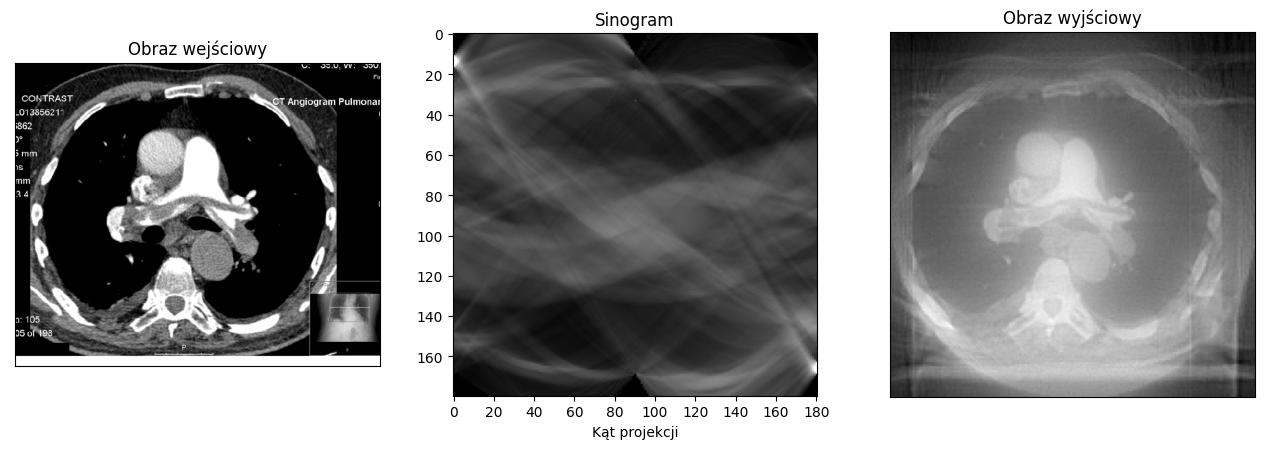

In [105]:
photo = imageio.imread('SADDLE_PE.JPG', mode = 'F')

plt.figure(figsize=(16,16))
plt.subplots_adjust(wspace=0.2)
sub1 = plt.subplot(131)
sub1.set_title("Obraz wejściowy")
sub1.set_xticks([],[])
sub1.set_yticks([],[])
sub1.imshow(photo, cmap='gray')


sinogram = Transf_Radona(photo, d_a, range_pi , n_detect, d_x)

xlabels=[i*20 for i in range(10)]
sub2 = plt.subplot(132)
sub2.set_xticks(np.arange(0, 181/d_x, 20/d_x))
sub2.set_xticklabels(xlabels)
sub2.set_xlabel("Kąt projekcji")
sub2.set_title("Sinogram")
sub2.imshow(sinogram, cmap='gray')


if filter == True:
    sinogram2 = filtration(sinogram)
else: 
    sinogram2 = sinogram
constr, projection = Back_Projection(sinogram2, d_x)

sub3 = plt.subplot(133)
sub3.set_title("Obraz wyjściowy")
sub3.set_xticks([],[])
sub3.set_yticks([],[])
sub3.imshow(constr, cmap='gray')